##  Spotify Song Recommendation System

We implement a content-based filtering approach for Spotify Song recommendation based on a [medium article](https://towardsdatascience.com/part-iii-building-a-song-recommendation-system-with-spotify-cf76b52705e7) for building a Spotify song recommendation system series.

In [2]:
import csv
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from operator import index
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re

In [3]:
# playlist_data = pd.read_csv("data/spotify.csv")

spotify_playlists = pd.read_csv('data/spotify_playlists.csv', encoding_errors='ignore', index_col=0, header=0)
spotify_playlists['playlist'].value_counts()

New Music Friday      100
New Pop Picks         100
just hits             100
Hip Hop Controller     99
RapCaviar              51
Today's Top Hits       50
Hot Hits USA           50
Name: playlist, dtype: int64

First, we want to check for song duplicates in the playlist. The following code uses the `drop_duplicates` function in **pandas** to drop duplicate songs while building an underlying dataframe with all unique content.

In [ ]:
# Duplicates of songs accross playlists
playlistDF = df.copy(deep = True)
playlistDF[['artist','name','playlist']].head(3)

In [ ]:
# Drop song duplicates
def drop_duplicates(df):
    df['artists_song']=df.apply(lambda row: row['artist']+' - '+row['name'],axis=1)
    return df.drop_duplicates('artists_song')

songDF = drop_duplicates(playlistDF)
print(len(pd.unique(songDF.artists_song)) == len(songDF))

For the audio features, we can categorize each attribute into four general categories as follows.

- **Mood**: Danceability, Energy, Tempo, Valence
- **Properties**: Instrumentalness, Loudness, Speechiness
- **Context**: Acousticness, Liveness
- **Metadata**: key, mode, time_signature


In [ ]:
songDF = songDF[[
    'name', 'track_id', 'release_date', 'popularity', # Track Metadata
    'artist', 'artist_id', 'artist_pop', 'artist_genres', # Artist Info
    'danceability', 'energy', 'valence', 'tempo', # Audio Features - Mood
    'instrumentalness', 'loudness', 'speechiness', # Audio Features - Properties
    'acousticness', 'liveness', # Audio Features - Context
    'key', 'mode', 'time_signature' # Audio Features - Metadata
]]

### Feature Generation


Data feature engineering methods are an integral part of recommender systems. We implement the following process into the feature generation pipeline. 

#### 1. Sentiment Analysis

The following code performs a simple sentiment analysis using the subjectivity and polarity forms from the TextBlob package. Subjectivity, on a scale from 0 to 1, is the amount of personal opinion and factual information in the text. Polarity, on a scale from -1 to 1, is the degree of sentimentality that leads to negation.

In [ ]:
# Get subjectivity & polarity using textblob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Categorize polarity & subjectivity score
def getAnalysis(score, task="polarity"):
    if task == "subjectivity":
        if score < 1/3:
            return "low"
        elif score > 1/3:
            return "high"
        else:
            return "medium"
    else:
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

# Perform sentiment analysis on text
def sentiment_analysis(df, text_col):
    df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
    df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
    return df

In [ ]:
sentimentDF = sentiment_analysis(songDF, "name")
sentimentDF[['name', 'artist', 'subjectivity', 'polarity']].head(3)

#### 2. One-Hot Encoding

We now use one-hot encoding to include the sentiment of a song as input. One-hot encoding converts categorical variables into a syntactic form that machines can understand. The first step involves converting each category into a column representing either True or False. 


![](https://iq.opengenus.org/content/images/2022/01/TW5m0aJ.png)

In [ ]:
# Create One Hot Encoded features of a specific column
def ohe_prep(df, column, new_name):
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    
    return tf_df # One-hot encoded features 

In [ ]:
# One-hot encoding for the subjectivity 
subject_ohe = ohe_prep(sentimentDF, 'subjectivity','subject')
subject_ohe.iloc[0]

#### 3. TF-IDF



Spotify's genres are imbalanced, with some more prevalent than others. Therefore, we weigh the importance of each genre to prevent overemphasizing some types and underestimating others. 

The Term Frequency-Inverse Document Frequency (TF-IDF) quantifies words in a set of documents, showing the importance of a word in the corpus: $ \text{Term Frequency}\times\text{Inverse Document Frequency}$.


The term frequency (TF) is the number of times a term appears in each document divided by the total word count, and the inverse document frequency (IDF) is the log value of the document frequency.


In [ ]:
# TF-IDF implementation
tfidf = TfidfVectorizer()
tfidf_matrix =  tfidf.fit_transform(songDF['artist_genres'].apply(lambda x: " ".join(x)))

# Genres dataframe
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
genre_df.reset_index(drop = True, inplace=True)
genre_df.iloc[0]

#### 4. Normalization


We need to normalize the popularity variable and audio features from 0 to 1. We use the MinMaxScaler function from scikit-learn, which automatically scales all values in min and max to the range 0 to 1.


In [ ]:
# artist_pop distribution descriptive stats
print(songDF['artist_pop'].describe())

Next, we apply hyperparameter tuning to the audio features of a song to improve the prediction. Specifically, the normalization of this data stems from the maximum and minimum values of each attribute.


In [ ]:
# Normalization
pop = songDF[["artist_pop"]].reset_index(drop = True)
scaler = MinMaxScaler()
pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns)
pop_scaled.head()

#### Feature Generation

Finally, we use the following code to generate all the above features and concatenate all the variables into a new data frame. We define the following function to process and create a final set of features to generate recommendations.


In [ ]:
def create_feature_set(df, float_cols):
    
    # Tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['artist_genres'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)
    
    # Sentiment analysis
    df = sentiment_analysis(df, "name")

    # One-hot encoding
    subject_ohe = ohe_prep(df, 'subjectivity','subject') * 0.3
    polar_ohe = ohe_prep(df, 'polarity','polar') * 0.5
    key_ohe = ohe_prep(df, 'key','key') * 0.5
    mode_ohe = ohe_prep(df, 'mode','mode') * 0.5

    # Normalization - scale popularity columns
    pop = df[["artist_pop","popularity"]].reset_index(drop = True)
    scaler = MinMaxScaler()
    pop_scaled = pd.DataFrame(scaler.fit_transform(pop), columns = pop.columns) * 0.2 

    # Scale audio feature columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    # Concanenate all features
    final = pd.concat([genre_df, floats_scaled, pop_scaled, subject_ohe, polar_ohe, key_ohe, mode_ohe], axis = 1)
    final.insert(loc=0, column='track_id', value=df['track_id'].values) # Add song name
    
    return final # Final set of features 

In [ ]:
# Save data and generate features
float_cols = songDF.dtypes[songDF.dtypes == 'float64'].index.values
complete_feature_set = create_feature_set(songDF, float_cols=float_cols)

# songDF.to_csv("../data/allsong_data.csv", index = False)
#complete_feature_set.to_csv("../data/complete_feature.csv", index = False)
complete_feature_set.head(3)

### Content-based Filtering Recommendation


The next step is to perform content-based filtering based on the song features. To do so, we concatenate all songs in a playlist into one summarization vector. Then, we find the similarity between the summarized playlist vector with all songs (not including the songs in the playlist) in the database. Then, we use the similarity measure retrieved the most relevant song that is not in the playlist to recommend it.



#### Choose Playlist


In this part, we test the data with *Mom's playlist* in the dataset.


In [ ]:
testDF = playlistDF[playlistDF['playlist'] == "but my feet in bottega"]

#### Extract features

The next step is to generate the features. We need to first use the `id` to differentiate songs that are in the playlist and those that are not. Then, we simply add the features for all songs in the playlist together as a summary vector.




In [ ]:
# Summarize playlist into a single vector
def generate_playlist_feature(feat_set, playlist_df):
    
    # Find song features in the playlist
    feat_set_playlist = feat_set[feat_set['track_id'].isin(playlist_df['track_id'].values)]    
    
    # Find all non-playlist song features
    feat_set_nonplaylist = feat_set[~feat_set['track_id'].isin(playlist_df['track_id'].values)]
    feat_set_playlist_final = feat_set_playlist.drop(columns = "track_id")
    
    # Single vector feature summarizing playlist
    return feat_set_playlist_final.sum(axis = 0), feat_set_nonplaylist

> In other words, this vector describes the whole playlist as if it is one song.


In [ ]:
# Generate the features
feat_set_pl, feat_set_nonpl = generate_playlist_feature(complete_feature_set, testDF)
# Non-playlist features feat_set_nonpl.head()

In [ ]:
# Summarized playlist features
complete_feature_set
feat_set_pl


#### Find similarity

In our code, we used the `cosine_similarity()` function from `scikit learn` to measure the similarity between each song and the summarized playlist vector.


In [ ]:
# Generated recommendation based on songs in aspecific playlist
def generate_playlist_recos(df, features, nonplaylist_features):
    '''
    features (pandas series): summarized playlist feature (single vector)
    nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
    '''
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    # Find cosine similarity between the playlist and the complete song set
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    
    # Top 40 recommendations for that playlist
    return non_playlist_df_top_40

--------------------------------------------------


## Clustering Playlist


### 1. Feature Preprocessing



In [129]:
dff = pd.read_csv('data/my_playlist.csv', encoding_errors='ignore', index_col=0, header=0)
X = dff[["acousticness", "danceability", "liveness","energy", "instrumentalness", 
       "loudness", "speechiness", "valence"]]

In [130]:
from sklearn import preprocessing 
scaler = preprocessing.MinMaxScaler() # intantiate a scaler
loudness = X["loudness"].values
X["loudness_scaled"] = scaler.fit_transform(loudness.reshape(-1, 1))

C:\conda_tmp\ipykernel_18244\1542361774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["loudness_scaled"] = scaler.fit_transform(loudness.reshape(-1, 1))


In [135]:
X = X[['acousticness', 'danceability', 'liveness', 'energy','valence',
       'instrumentalness', 'speechiness']]
features=X.values

### 2. Selecting the right KMeans model


In [136]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,21) #let's use elbow method to find out what the optimal k is 
for k in K:
    model = KMeans(n_clusters=k)
    model = model.fit(features)
    Sum_of_squared_distances.append(model.inertia_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


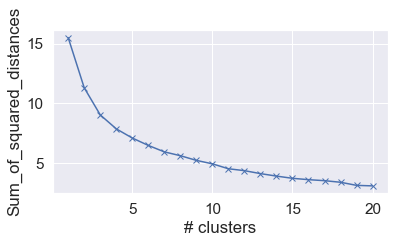

In [137]:
import matplotlib.pyplot as plt #Elbow method
plt.figure(figsize=(6,3))
plt.plot(list(range(1,21)),Sum_of_squared_distances,'bx-')
plt.ylabel('Sum_of_squared_distances')
plt.xlabel('# clusters')
plt.show()

In [139]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model = model.fit(features)

### 3. Clustering

In [140]:
predictions=model.predict(features) #make predictions
dff['cluster']=predictions

### 4. Visualization of the derived clusters

In [141]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 2)
pca_result = pca.fit_transform(features)
df_pca = pd.DataFrame(pca_result)
df_pca['cluster']=predictions


C:\conda_tmp\ipykernel_18244\2308926359.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter)
C:\conda_tmp\ipykernel_18244\2308926359.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


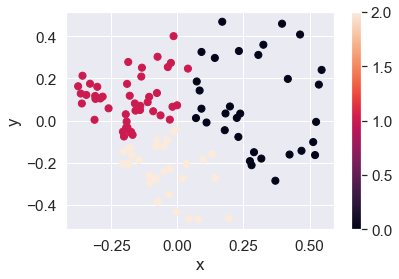

In [142]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

scatter = ax.scatter(df_pca.iloc[:,0].values, df_pca.iloc[:,1].values,c=predictions,s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()

----------------

### 5. Selecting a classifier
Let's determine the best model to use for future classification. It can be used to classify recommended songs by Spoitfy or to classify already saved songs.


In [143]:
df_classify=dff[["acousticness", "danceability", "liveness","energy", "instrumentalness", "speechiness","cluster"]]#selecting features
X=df_classify.iloc[:,:-1].values
Y=df_classify.iloc[:,-1].values

#### Splitting the dataset into the Training set and Test set


In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2)
X_train[:,5]=scaler.fit_transform(X_train[:,5].reshape(-1, 1)).reshape(-1,)
X_test[:,5]=scaler.transform(X_test[:,5].reshape(-1, 1)).reshape(-1,)

#### Selecting a classifier

There are four models compared in terms of accuracy, which are KNeighborsClassifier,RandomForestClassifier, Support Vector Classifier and Naive Bayes. Support Vector Classifier tourned out to be the best model in terms of accuracy, which made up roughly 0.998, hence we will be using it for future classification.


In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
acc=[]
for i in range(2,10):
    classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    print(f'{i}:{acc[-1]}')

2:0.5909090909090909
3:0.6363636363636364
4:0.6363636363636364
5:0.6363636363636364
6:0.6363636363636364
7:0.6363636363636364
8:0.6818181818181818
9:0.5454545454545454


In [164]:
classifier = SVC(kernel ='poly', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[6 0 0]
 [1 7 2]
 [0 5 1]]


#### Clusters' description

Cluster 0 is tourned out to be very high in terms of speechiness since the mean value over all songs is 0.87. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech. Moreover, it is low in instrumentalness but pretty high in danceability. I assume there are mostly rap songs. Cluster 1 is relatively high in danceability and energy but low in instrumentalness. I expect to see a lot of energetic songs there. Cluster 2 is very high in acousticness but low in instrumentalness and loudness. Moreover, it has quite high danceability magnitude. Therefore, I expect to see more calm, perhaps sad, songs. Cluster 3 is the highest in acousticness and instrumentalness but the lowest in speechiness. Cluster 4 is quite high in instrumentalness and energy and average in danceability.

In [153]:
df2=dff[["track_id","acousticness", "danceability", "liveness","energy", "instrumentalness", "loudness", "speechiness","cluster"]]
cluster_info=[]
for i in range(5):
    cluster_info.append(df2[df2['cluster']==i].describe().iloc[1,:])
cluster_info

[acousticness        0.539687
 danceability        0.737625
 liveness            0.151313
 energy              0.537219
 instrumentalness    0.022516
 loudness           -7.627188
 speechiness         0.158881
 cluster             0.000000
 Name: mean, dtype: float64,
 acousticness        0.141199
 danceability        0.640227
 liveness            0.165268
 energy              0.581545
 instrumentalness    0.000242
 loudness           -6.616409
 speechiness         0.136611
 cluster             1.000000
 Name: mean, dtype: float64,
 acousticness        0.119303
 danceability        0.675100
 liveness            0.157257
 energy              0.647800
 instrumentalness    0.000247
 loudness           -6.515033
 speechiness         0.153993
 cluster             2.000000
 Name: mean, dtype: float64,
 acousticness       NaN
 danceability       NaN
 liveness           NaN
 energy             NaN
 instrumentalness   NaN
 loudness           NaN
 speechiness        NaN
 cluster            NaN
 

--------------------

In [154]:
mydf = df2.set_index('track_id')


In [155]:
clustered_songs=list(zip(mydf.index,mydf.iloc[:,-1]))
sorted_songs=[[],[],[],[],[]]
for i in range(len(clustered_songs)):
    sorted_songs[clustered_songs[i][1]].append(clustered_songs[i][0])

In [157]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
# Set client id and client secret
cid = '4cf3afdca2d74dc48af9999b1b7c9c61'
secret = 'f6ca08ad37bb41a0afab5ca1dc74b208'
username = 'hannahluebbering' # Your Spotify username
scope = 'user-library-read playlist-read-private user-top-read playlist-modify-private user-read-currently-playing'
redirect_uri='http://localhost:1410/'
scope = 'user-library-read playlist-modify-public playlist-read-private user-top-read playlist-modify-private user-read-currently-playing'

client_credentials_manager = spotipy.oauth2.SpotifyOAuth(scope=scope, username=username,
                                                         client_id=cid, client_secret=secret, 
                                                         redirect_uri=redirect_uri) 
                                                         #cache_path='./tokens.txt') 
SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [159]:
playlists=[]
for i in range(3):
    #create playlists for a corresponding cluster
    playlist_created=sp.user_playlist_create(username, name="Cluster "+str(i), public=False,description='')
    #add new songs
    sp.playlist_add_items(playlist_created['id'], sorted_songs[i][:100])
    #sp.user_playlist_add_tracks(username,sorted_songs[i][:100])
    playlists.append(playlist_created)

In [162]:
len_clusters=[]
for i in range(3):
    len_clusters.append(len(mydf[mydf['cluster']==i].values))

In [163]:
len_clusters

[32, 44, 30]